In [1]:
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pathlib import Path
from pvlib.irradiance import get_extra_radiation
from pvlib.solarposition import get_solarposition
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
)
from timezonefinder import TimezoneFinder
from tqdm import tqdm
from lightgbm import LGBMRegressor

# from models_utils.preprocessing import add_night_mark


import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

# Utilities

In [2]:
def plot_corr(df):
    for i, method in enumerate(("pearson", "spearman")):
        corr_mat = df.corr(method=method)
        mask = np.zeros_like(corr_mat, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(20, 10))
        sns.heatmap(
            data=corr_mat,
            mask=mask,
            annot=True,
            fmt='.2f',
            vmax=1,
            center=0,
            square=True,
            linewidth=.5,
            cbar_kws={'shrink': .5},
        );
        plt.title(method)

In [3]:
def show_info(df: pd.DataFrame):
    display(df.head())
    # print(f"\nStart {df.time.min()}", f"End {df.time.max()}\n", sep="\n")
    display(df.info())
    print()
    df.hist(figsize=(15, 15));
    plot_corr(df)

# Constants

In [4]:
PROJECT_PATH = Path.cwd()
DATA_PATH = PROJECT_PATH / "data"
WEATHER_PATH = DATA_PATH / "chatham_weather_year.csv"
IRRAD_PARH = DATA_PATH / "irradiance_sensor_year.csv"
TESLA_DATA_PATH = DATA_PATH / "tesla_year.csv"
PVLIB_DATA_PATH = DATA_PATH / "pvlib_data_year.csv"

LATITUDE = 51.381
LONGITUDE = 0.522
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIME_COLUMN = "time"

# Data read

In [129]:
weather_data = pd.read_csv(WEATHER_PATH, parse_dates=["time"], skiprows=3)
irrad_data = pd.read_csv(IRRAD_PARH, parse_dates=["time"])
tesla_data = pd.read_csv(TESLA_DATA_PATH, parse_dates=["time"])
pvlib_data = pd.read_csv(PVLIB_DATA_PATH, parse_dates=["time"])

# Preprocessing

In [130]:
# weather_data = weather_data.drop([i for i in range(2208, 2301)])

In [131]:
weather_data = weather_data.drop([8760])

In [132]:
# dropping_columns = list(filter(lambda col: "radia" in col or "snowfall" in col, weather_data.columns))
# weather_data.drop(columns=dropping_columns, inplace=True)
# weather_data = weather_data.assign(time=weather_data.time.dt.tz_localize(TIMEZONE))
weather_data['time'] = pd.to_datetime(weather_data['time'], utc = True)
# weather_data = weather_data.assign(time=weather_data.time.dt.tz_convert(TIMEZONE))
# irrad_data['time'] = pd.to_datetime(irrad_data['time'], utc = True)
tesla_data['time'] = pd.to_datetime(tesla_data['time'], utc = True)
solar_power_data = tesla_data[["time", "solar_power"]]
solar_power_data["solar_power"].clip(lower=0, inplace=True)
# pvlib_data['time'] = pd.to_datetime(pvlib_data['time'], utc = True)

/tmp/ipykernel_7893/1096791399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_power_data["solar_power"].clip(lower=0, inplace=True)


In [133]:
# weather_data_daily = weather_data[DAILY_FEATURES_COLUMNS + [TIME_COLUMN]]

In [134]:
# weather_data_daily = weather_data_daily.set_index("time")
# display(weather_data_daily)

In [135]:
# weather_data_daily = weather_data_daily.resample('24H').mean()

In [136]:
# weather_data_daily = weather_data_daily.resample('H').ffill()

In [137]:
# weather_data_daily = weather_data_daily.reset_index()

In [138]:
# weather_data_hourly = weather_data.drop(columns=DAILY_FEATURES_COLUMNS)

In [139]:
# irrad_data = irrad_data[["time", "solar_irrad"]]

In [166]:
solar_power_data.solar_power = solar_power_data.solar_power.shift(2)
# solar_power_data["solar_power_prevprev"] = solar_power_data.solar_power.shift(2)

/tmp/ipykernel_7893/4090945557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_power_data.solar_power = solar_power_data.solar_power.shift(1)


In [167]:
 # irrad_data = irrad_data.assign(
#     time=pd.to_datetime(
#         irrad_data["# Observation period"]
#         .str
#         .split("/")
#         .apply(lambda l: l[0])
#     )
#     .dt.tz_localize(TIMEZONE)
# )
# irrad_data.drop(columns=["# Observation period",], inplace=True)
# irrad_data = irrad_data.resample('1H', on="time").mean().reset_index()

## Merge

In [168]:
# merged_data = solar_power_data.merge(irrad_data, on=TIME_COLUMN)
# merged_data = merged_data.merge(pvlib_data, on=TIME_COLUMN)
# merged_data = merged_data.merge(weather_data, on=TIME_COLUMN)
merged_data = solar_power_data.merge(weather_data, on=TIME_COLUMN)
# prepared_data = merged_data.copy()
# prepared_data = add_night_mark(
#     merged_data,
#     lat=LATITUDE,
#     lon=LONGITUDE,
#     timezone=TIMEZONE,
#     date_column=TIME_COLUMN,
#     mark_column="night_mark",
#     night_indent=timedelta(),
# )
# mask = ~prepared_data["night_mark"]
# prepared_data = prepared_data[mask].reset_index(drop=True)
# prepared_data.drop(columns=["night_mark"], inplace=True)
# prepared_data = (
#     prepared_data
#     .assign(
#         year=prepared_data.time.dt.year,
#         day_of_year=prepared_data.time.dt.day_of_year,
#         extrater_irrad=0,
#         zenith_coef=0,
#     )
# )
# for year in prepared_data.year.unique():
#     year_mask = prepared_data.year == year
#     doys = prepared_data.loc[year_mask, "day_of_year"]
#     prepared_data.loc[year_mask, "extrater_irrad"] = get_extra_radiation(doys, year=year)
# for temperature in tqdm(prepared_data[TEMPERATURE_COL].unique()):
#     temp_mask = prepared_data[TEMPERATURE_COL] == temperature
#     prepared_data.loc[temp_mask, "zenith_coef"] = np.cos(get_solarposition(
#         prepared_data.loc[temp_mask, TIME_COLUMN],
#         latitude=LATITUDE,
#         longitude=LONGITUDE,
#         temperature=temperature)["zenith"].values)
# zenith_coef = prepared_data["zenith_coef"].values
# prepared_data["zenith_coef"] = prepared_data["zenith_coef"].where(
#     np.abs(zenith_coef) > COS_EPS,
#     zenith_coef + np.sign(zenith_coef) * COS_EPS,
# )
# prepared_data["direct_noise"] = prepared_data["extrater_irrad"] - prepared_data["BHI"] / prepared_data["zenith_coef"]
# prepared_data.drop(columns=["year", "day_of_year", "extrater_irrad", "zenith_coef",], inplace=True)

In [169]:
merged_data = merged_data.dropna()

In [170]:
merged_data[['temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)',
       'precipitation (mm)', 'rain (mm)', 'weathercode (wmo code)',
       'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)']] = merged_data[['temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)',
       'precipitation (mm)', 'rain (mm)', 'weathercode (wmo code)',
       'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)']].astype(float)

In [171]:
# cloudcover_data_daily = merged_data[["time",
#                                      "cloudcover (%)",
#                                      "cloudcover_mid (%)",
#                                      "cloudcover_high (%)",
#                                      "cloudcover_low (%)",
#                                      "rain (mm)",
#                                      "relativehumidity_2m (%)",
#                                      "windspeed_10m (km/h)",
#                                      "windspeed_100m (km/h)"]]

In [159]:
# cloudcover_data_daily = cloudcover_data_daily.set_index("time")
# cloudcover_data_daily = cloudcover_data_daily.resample('24H').mean()
# cloudcover_data_daily = cloudcover_data_daily.resample('H').ffill()
# cloudcover_data_daily = cloudcover_data_daily.reset_index()

In [160]:
# merged_data["cloudcover_multiplicator"] = cloudcover_data_daily["cloudcover (%)"] \
#                                           * (merged_data["dni"] + merged_data["dhi"] + merged_data["ghi"])
# merged_data["rain_multiplicator"] = cloudcover_data_daily["rain (mm)"] \
#                                     * (merged_data["dni"] + merged_data["dhi"] + merged_data["ghi"])

In [161]:
# plt.figure(figsize=(25, 15))
# plt.scatter(merged_data["solar_irrad"], merged_data["rain_multiplicator"],
#             label='predicted')
# plt.legend(loc="best")
# plt.axis("tight")
# plt.title("solar power")
# plt.grid(True)

In [162]:
# merged_data["mul"] = merged_data["cloudcover_mid (%)"] * (merged_data["direct_radiation (W/m²)"] +
#              merged_data["direct_normal_irradiance (W/m²)"] +
#              merged_data["diffuse_radiation (W/m²)"])

In [163]:
merged_data

,time,solar_power,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),precipitation (mm),rain (mm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),vapor_pressure_deficit (kPa)
0,2022-06-01 00:00:00+00:00,0.000,10.3,80.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,9.4,10.5,0.25
2,2022-06-01 01:00:00+00:00,0.000,9.6,80.0,6.4,0.0,0.0,2.0,73.0,10.0,61.0,91.0,0.0,0.0,0.0,0.0,7.4,6.0,0.23
3,2022-06-01 02:00:00+00:00,0.000,9.0,80.0,5.8,0.0,0.0,2.0,79.0,20.0,76.0,50.0,0.0,0.0,0.0,0.0,7.1,6.0,0.23
4,2022-06-01 03:00:00+00:00,0.000,8.6,81.0,5.5,0.0,0.0,1.0,41.0,3.0,63.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.21
5,2022-06-01 04:00:00+00:00,0.000,8.2,83.0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037,2023-05-30 16:00:00+00:00,2765.278,15.1,66.0,8.8,0.0,0.0,3.0,90.0,100.0,0.0,0.0,544.0,240.0,304.0,326.9,22.9,31.1,0.58
9038,2023-05-30 17:00:00+00:00,1613.062,14.8,68.0,8.9,0.0,0.0,3.0,90.0,100.0,0.0,0.0,400.0,141.0,259.0,276.7,23.5,31.9,0.54
9039,2023-05-30 18:00:00+00:00,845.001,14.2,70.0,8.8,0.0,0.0,3.0,90.0,100.0,0.0,0.0,256.0,84.0,172.0,196.9,23.6,33.1,0.49
9040,2023-05-30 19:00:00+00:00,675.062,13.6,72.0,8.6,0.0,0.0,3.0,90.0,100.0,0.0,0.0,138.0,12.0,126.0,100.1,23.9,33.9,0.44


In [172]:
merged_data = merged_data.set_index("time")

<Axes: xlabel='time'>

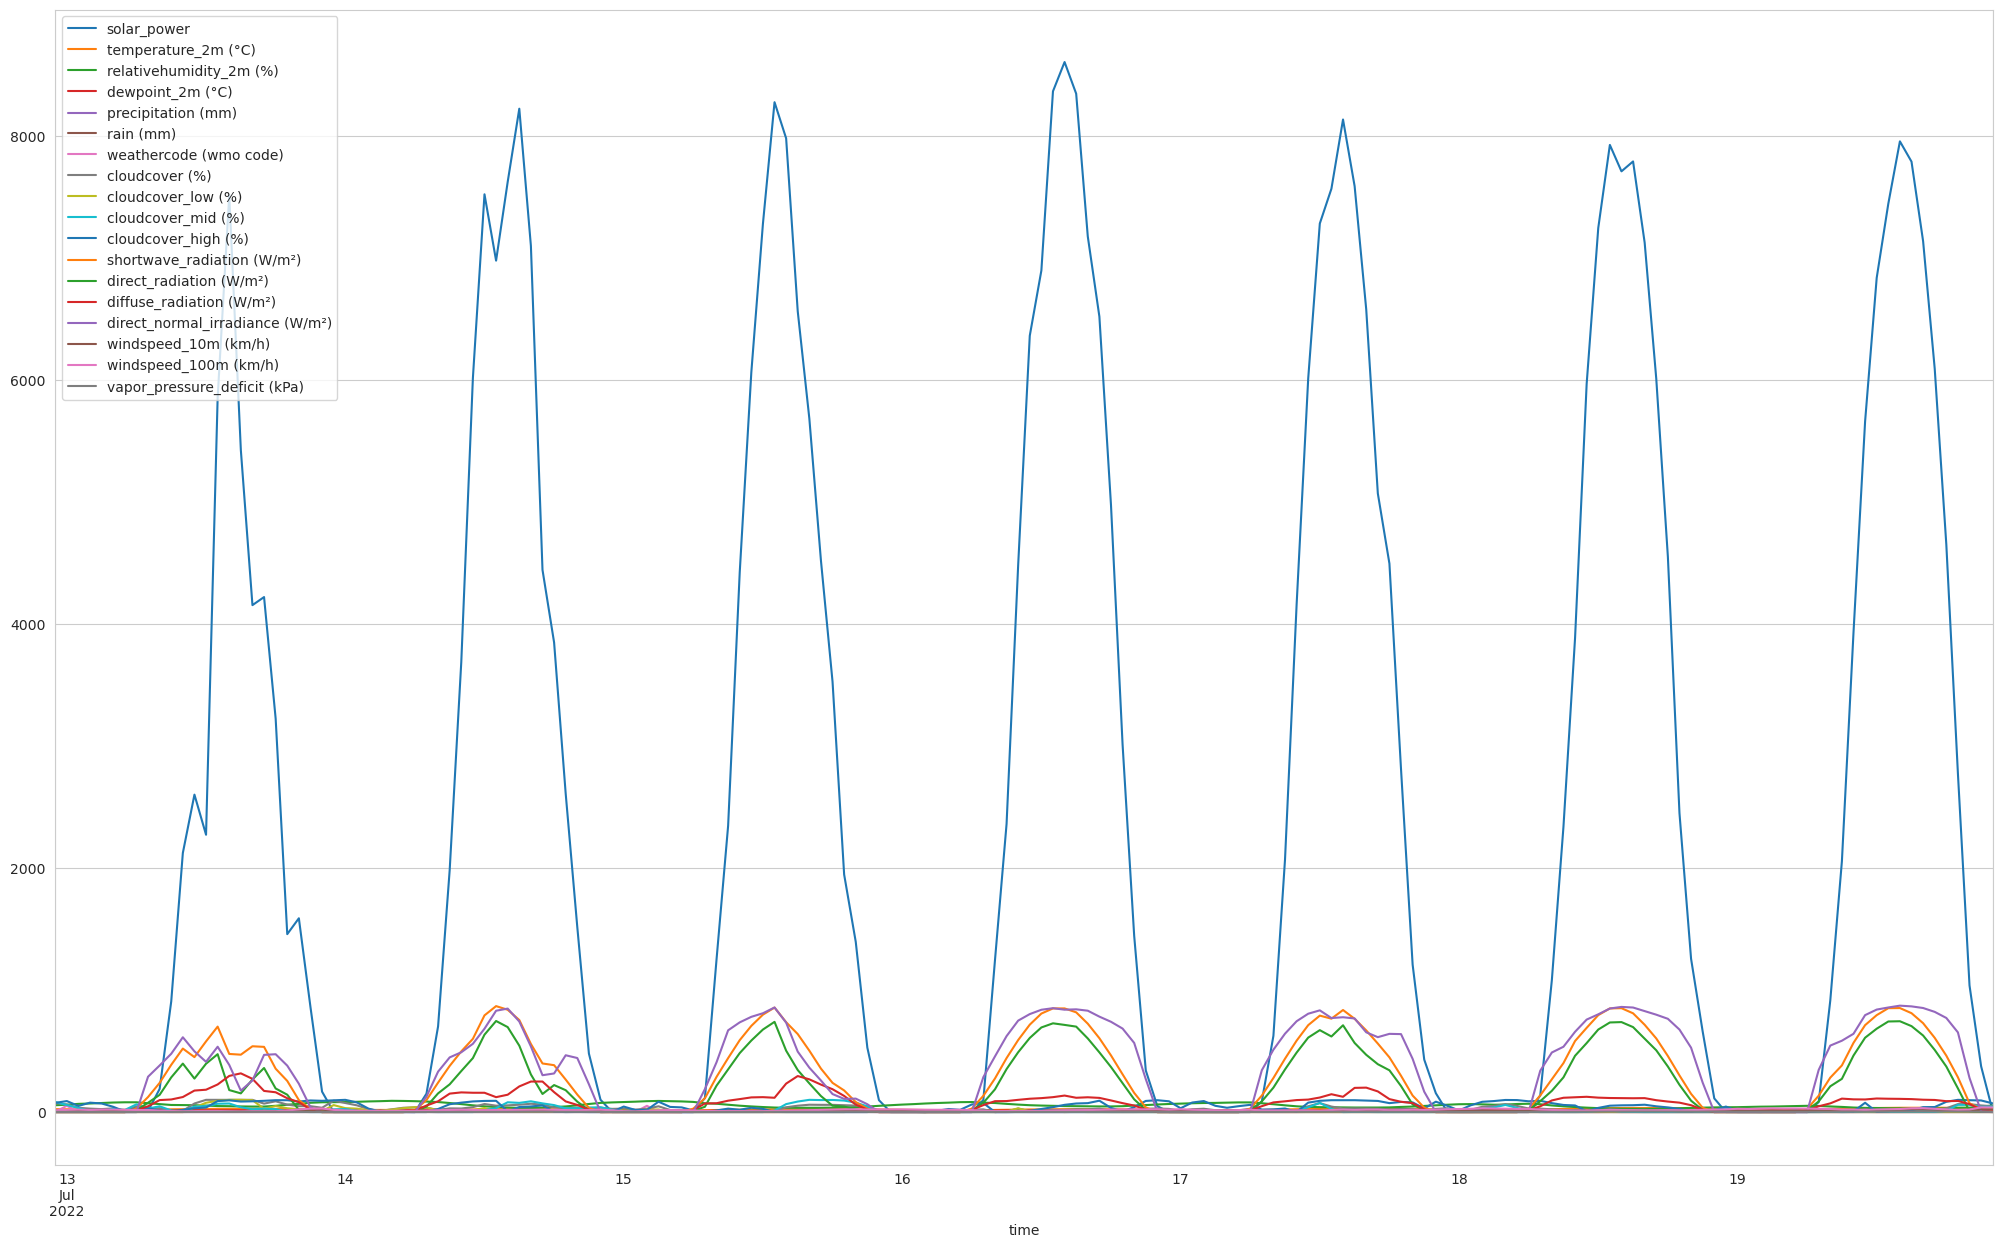

In [173]:
from_timestamp = pd.Timestamp(year=2022, month=7, day=13, tz=TIMEZONE)
to_timestamp = pd.Timestamp(year=2022, month=7, day=20, tz=TIMEZONE)
merged_data[from_timestamp : to_timestamp].plot(figsize=(25, 15))

,time,solar_power,solar_power_prev,solar_power_prevprev,solar_irrad,ghi,dni,dhi,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),precipitation (mm),rain (mm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),vapor_pressure_deficit (kPa)
0,2022-06-01 00:00:00+00:00,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,10.3,80.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,9.4,10.5,0.25
2,2022-06-01 01:00:00+00:00,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,9.6,80.0,6.4,0.0,0.0,2.0,73.0,10.0,61.0,91.0,0.0,0.0,0.0,0.0,7.4,6.0,0.23
3,2022-06-01 02:00:00+00:00,0.000,0.0,0.0,0.000,0.000000,0.000000,0.000000,9.0,80.0,5.8,0.0,0.0,2.0,79.0,20.0,76.0,50.0,0.0,0.0,0.0,0.0,7.1,6.0,0.23
4,2022-06-01 03:00:00+00:00,0.000,0.0,0.0,0.137,0.000000,0.000000,0.000000,8.6,81.0,5.5,0.0,0.0,1.0,41.0,3.0,63.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.21
5,2022-06-01 04:00:00+00:00,141.505,0.0,0.0,2.735,0.155452,0.387981,0.149963,8.2,83.0,5.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,0.19


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8110 entries, 0 to 8446
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   time                             8110 non-null   datetime64[ns, UTC]
 1   solar_power                      8110 non-null   float64            
 2   solar_power_prev                 8110 non-null   float64            
 3   solar_power_prevprev             8110 non-null   float64            
 4   solar_irrad                      8110 non-null   float64            
 5   ghi                              8110 non-null   float64            
 6   dni                              8110 non-null   float64            
 7   dhi                              8110 non-null   float64            
 8   temperature_2m (°C)              8110 non-null   float64            
 9   relativehumidity_2m (%)          8110 non-null   float64            
 10  

None

/tmp/ipykernel_12643/3401427597.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df.corr(method=method)


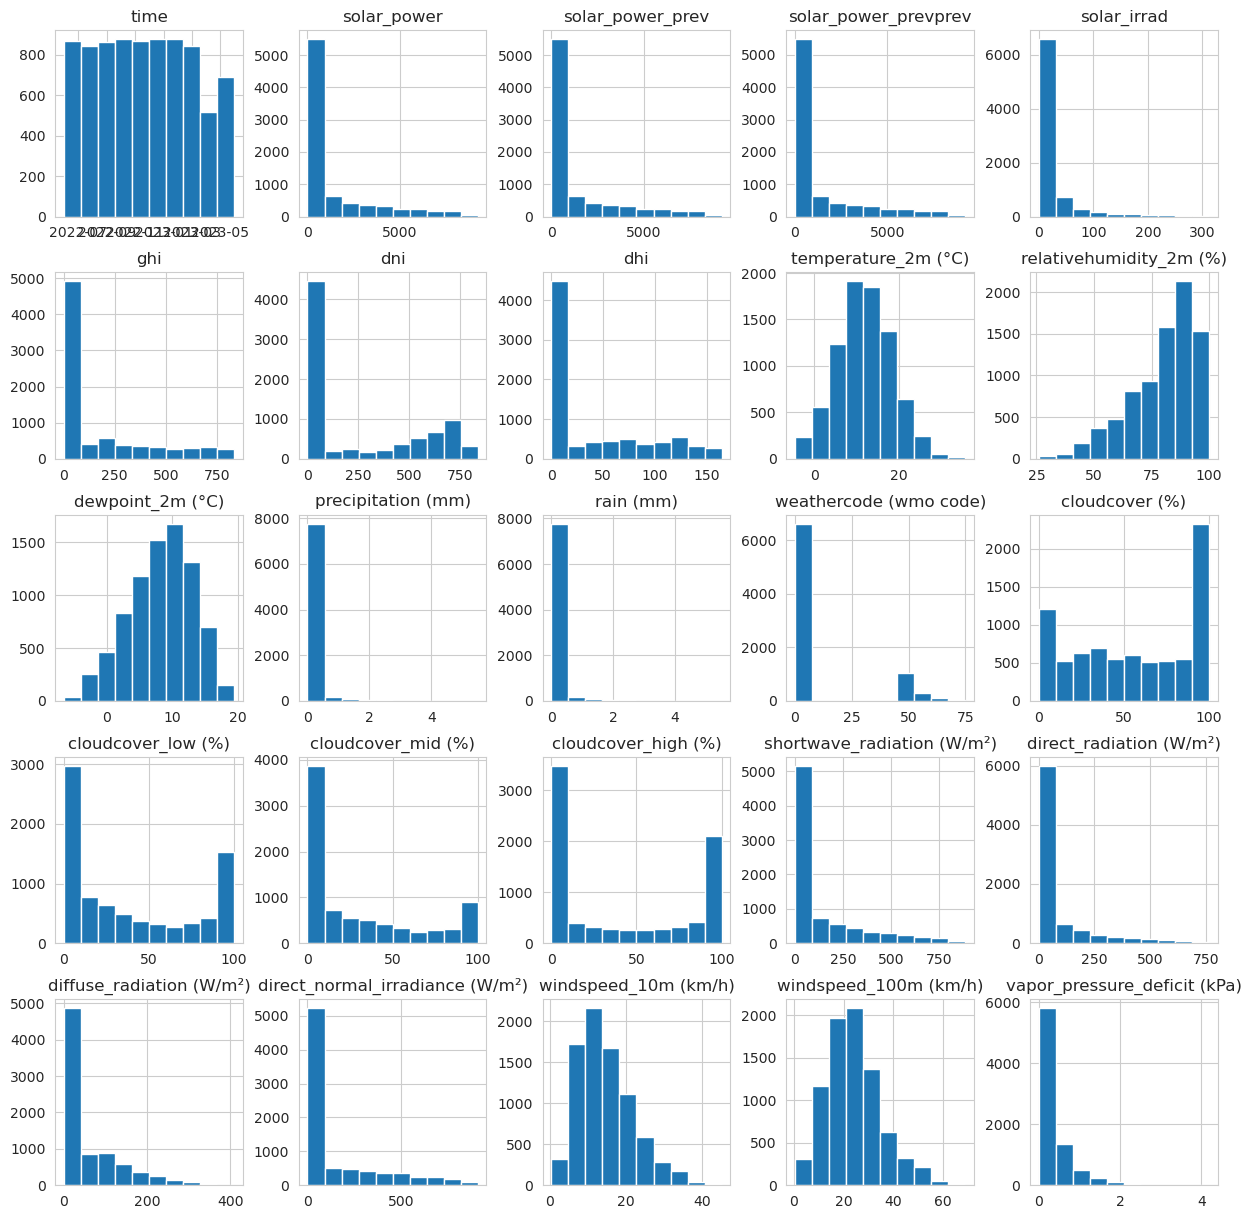

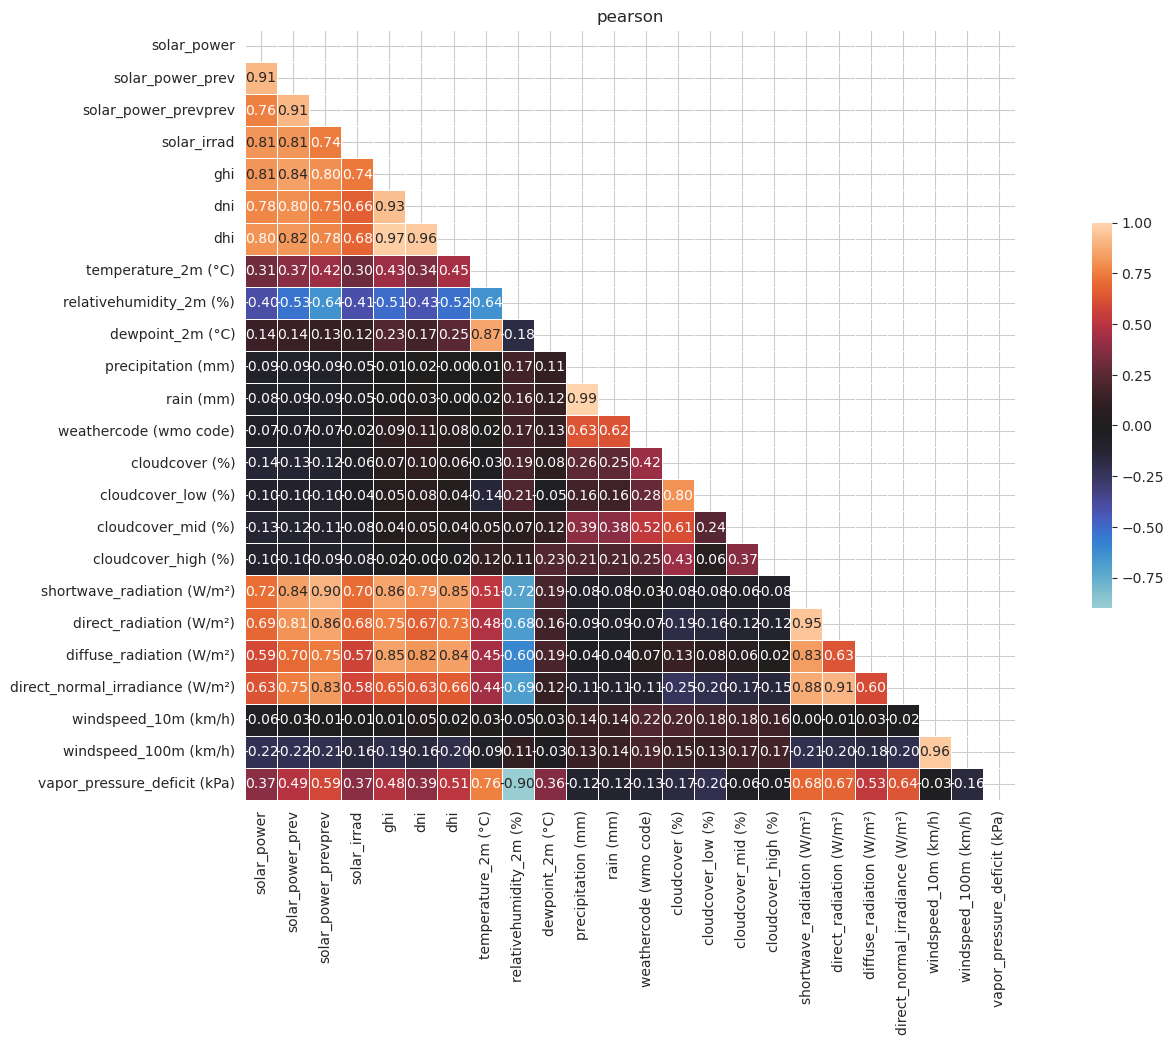

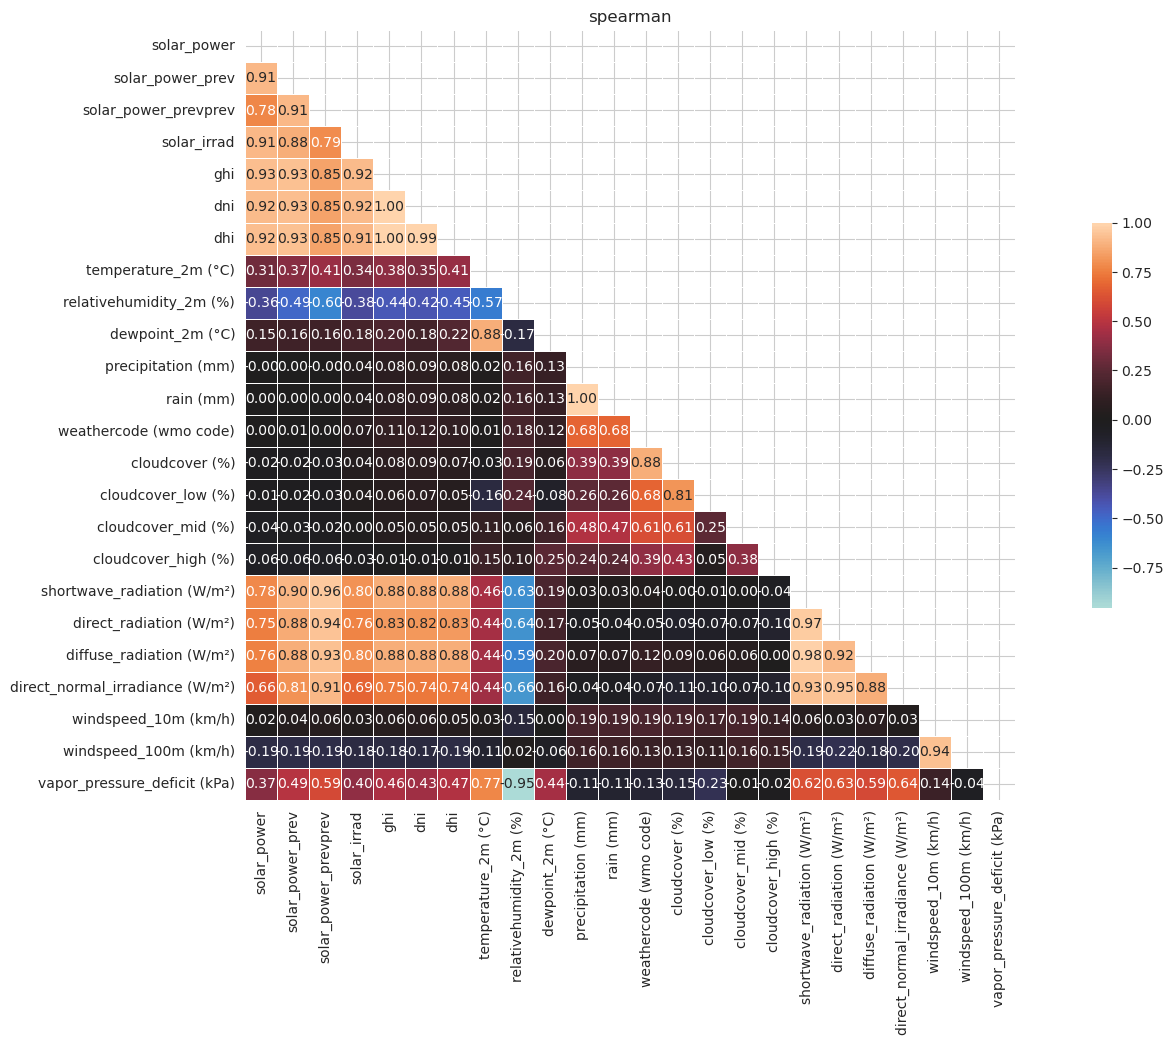

In [26]:
show_info(merged_data)

In [27]:
merged_data_daily = merged_data.set_index("time")
merged_data_daily = merged_data_daily.resample('24H').mean()
merged_data_daily = merged_data_daily.reset_index()

In [32]:
merged_data_daily = merged_data_daily.dropna()

,time,solar_power,solar_power_prev,solar_power_prevprev,solar_irrad,ghi,dni,dhi,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),precipitation (mm),rain (mm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),vapor_pressure_deficit (kPa)
0,2022-06-01 00:00:00+00:00,1816.380708,1816.380708,1816.380708,34.208667,311.569830,379.544547,65.529463,12.741667,71.916667,7.654167,0.050000,0.050000,9.541667,45.708333,19.625000,44.916667,6.083333,260.750000,165.958333,94.791667,261.425000,6.245833,15.350000,0.447917
1,2022-06-02 00:00:00+00:00,2650.892833,2650.892833,2650.892833,58.185792,311.762902,378.170003,66.114625,13.679167,74.791667,8.812500,0.004167,0.004167,2.791667,25.958333,17.125000,7.458333,20.083333,303.375000,212.708333,90.666667,345.395833,11.037500,16.087500,0.459167
2,2022-06-03 00:00:00+00:00,2503.908875,2503.908875,2503.908875,41.358000,311.911989,376.771631,66.690952,15.212500,76.833333,10.958333,0.029167,0.029167,9.166667,26.000000,1.500000,23.708333,34.333333,284.041667,187.583333,96.458333,298.412500,15.445833,24.550000,0.438750
3,2022-06-04 00:00:00+00:00,1139.459417,1139.459417,1139.459417,18.316000,312.017044,375.349486,67.258294,14.450000,80.458333,11.037500,0.179167,0.179167,22.583333,56.041667,12.875000,41.708333,78.875000,258.541667,158.875000,99.666667,233.712500,24.162500,35.979167,0.335833
4,2022-06-05 00:00:00+00:00,449.899750,449.899750,449.899750,8.164917,312.078028,373.903594,67.816491,14.470833,85.458333,11.966667,0.420833,0.420833,22.916667,97.250000,86.041667,43.166667,76.708333,149.125000,37.875000,111.250000,57.079167,13.179167,20.041667,0.254583


<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 352
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   time                             339 non-null    datetime64[ns, UTC]
 1   solar_power                      339 non-null    float64            
 2   solar_power_prev                 339 non-null    float64            
 3   solar_power_prevprev             339 non-null    float64            
 4   solar_irrad                      339 non-null    float64            
 5   ghi                              339 non-null    float64            
 6   dni                              339 non-null    float64            
 7   dhi                              339 non-null    float64            
 8   temperature_2m (°C)              339 non-null    float64            
 9   relativehumidity_2m (%)          339 non-null    float64            
 10  de

None

/tmp/ipykernel_12643/3401427597.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = df.corr(method=method)


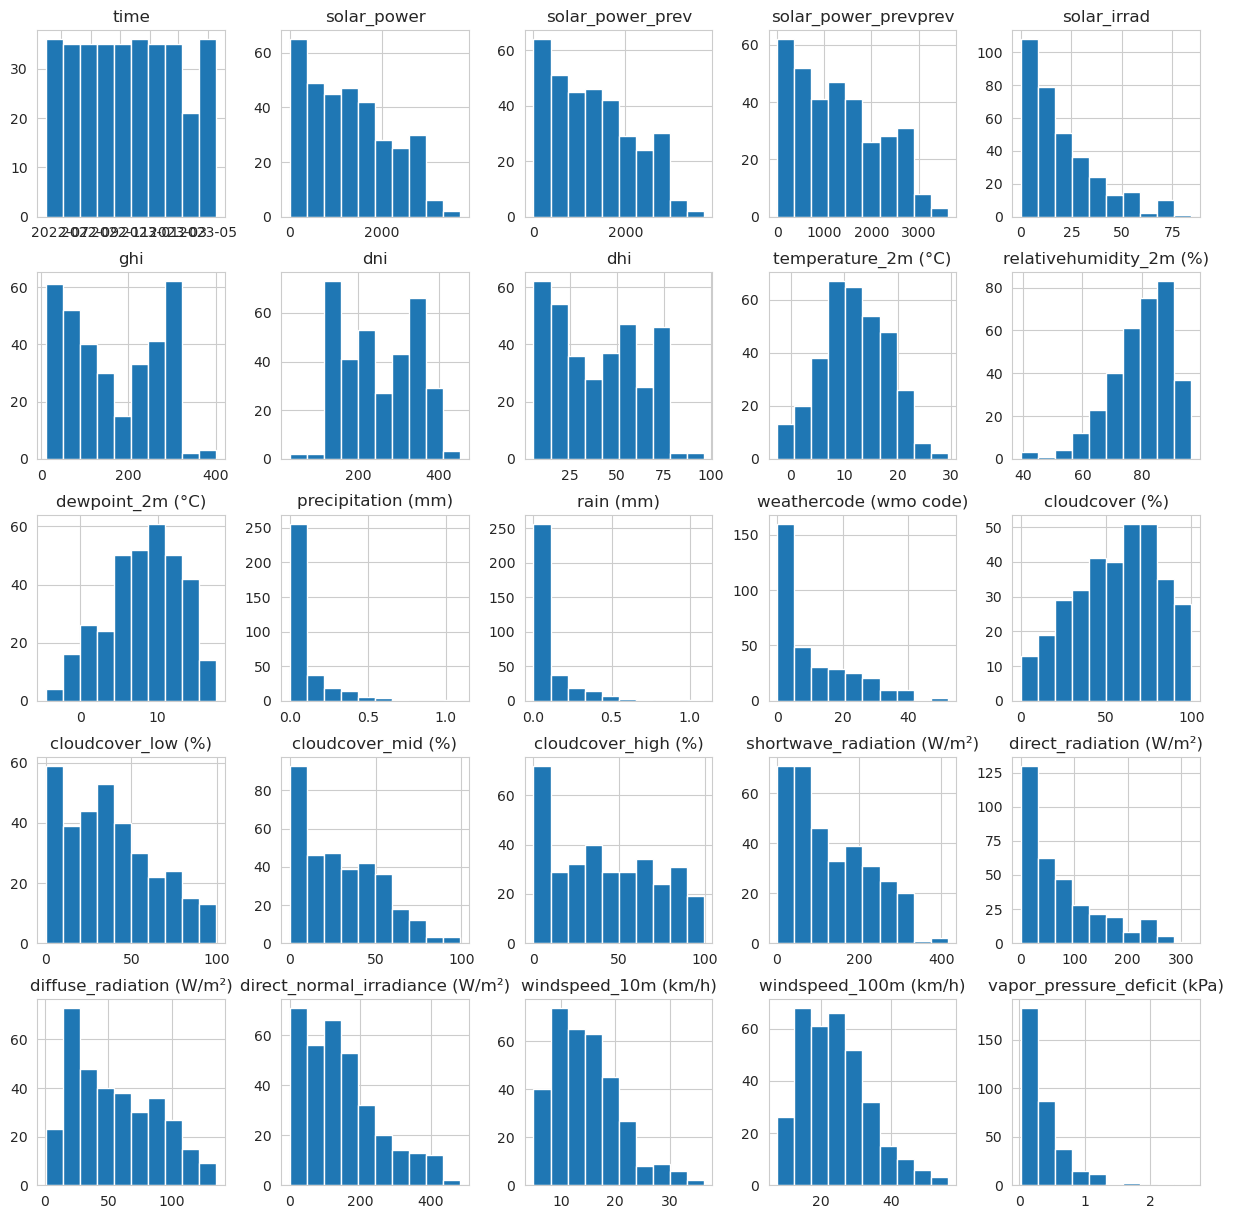

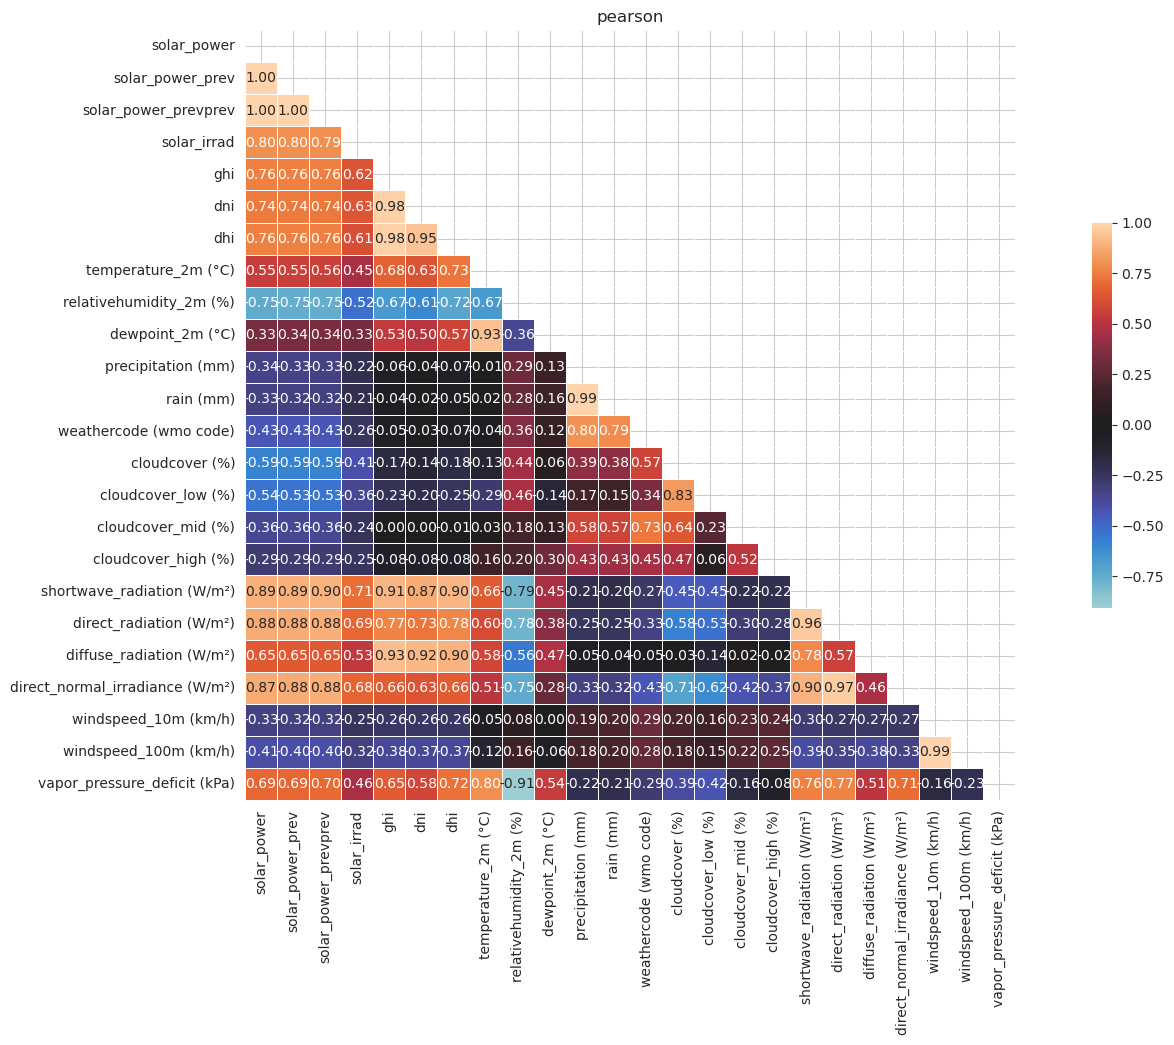

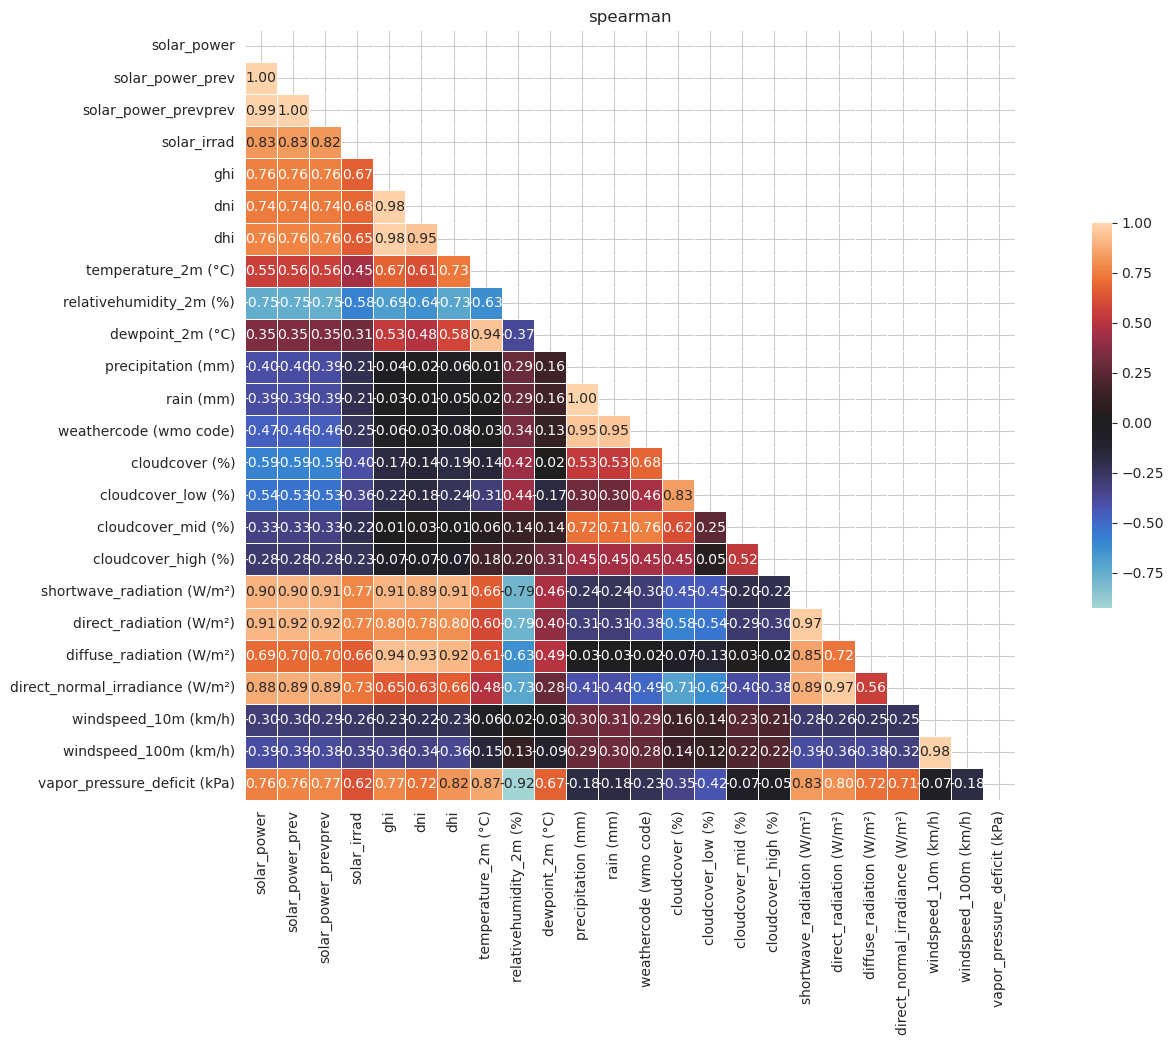

In [33]:
show_info(merged_data_daily)

# Data separation

In [34]:
test_sample = merged_data_daily[-7:]
merged_data_daily = merged_data_daily[:-7]

In [35]:
test_sample

,time,solar_power,solar_power_prev,solar_power_prevprev,solar_irrad,ghi,dni,dhi,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),precipitation (mm),rain (mm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),vapor_pressure_deficit (kPa)
346,2023-05-13 00:00:00+00:00,1528.019833,1528.019833,1528.019833,23.416792,297.210079,393.188385,54.402123,12.262500,81.708333,9.108333,0.000000,0.000000,2.125000,70.583333,70.916667,20.291667,0.250000,239.875000,144.750000,95.125000,239.116667,17.725000,25.816667,0.287083
347,2023-05-14 00:00:00+00:00,2122.849792,2122.849792,2122.849792,42.179375,299.026854,395.230715,54.500156,13.108333,79.416667,9.316667,0.000000,0.000000,2.000000,62.958333,52.750000,8.666667,35.458333,254.250000,143.833333,110.416667,224.300000,5.466667,8.812500,0.378333
348,2023-05-15 00:00:00+00:00,2335.171708,2335.171708,2335.171708,35.221708,300.806478,397.235519,54.590375,12.108333,71.458333,6.850000,0.012500,0.012500,8.041667,64.333333,26.458333,50.125000,51.000000,207.708333,96.708333,111.000000,158.991667,16.216667,24.858333,0.412083
349,2023-05-16 00:00:00+00:00,2643.485542,2643.485542,2643.485542,41.978958,302.146703,397.759539,54.992685,11.416667,73.250000,6.454167,0.000000,0.000000,1.125000,38.291667,34.375000,19.875000,0.000000,247.000000,158.875000,88.125000,269.345833,10.429167,16.579167,0.408333
350,2023-05-17 00:00:00+00:00,2062.749292,2062.749292,2062.749292,25.855125,303.044586,396.810576,55.707595,11.866667,78.958333,8.170833,0.045833,0.045833,13.750000,58.791667,21.291667,42.750000,57.041667,217.416667,116.666667,100.750000,198.600000,8.441667,13.229167,0.324583
351,2023-05-18 00:00:00+00:00,2940.603208,2940.603208,2940.603208,51.619708,303.900441,395.833437,56.415194,11.962500,73.666667,7.250000,0.000000,0.000000,1.000000,34.333333,6.958333,33.875000,25.708333,303.625000,240.291667,63.333333,383.033333,7.875000,11.787500,0.393333
352,2023-05-19 00:00:00+00:00,2408.295200,2039.692867,1602.689333,33.024867,376.083010,453.462074,66.436846,10.873333,81.066667,7.600000,0.013333,0.013333,8.000000,52.266667,1.200000,55.800000,58.466667,214.400000,81.733333,132.666667,117.633333,8.166667,11.853333,0.274667


In [64]:
TARGET_COLUMN = "solar_irrad"
FEATURES_COLUMNS = ['ghi', 'dni', 'dhi',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'rain (mm)', 'weathercode (wmo code)', 'cloudcover (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
                        'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', "windspeed_10m (km/h)", "windspeed_100m (km/h)", "vapor_pressure_deficit (kPa)"]

In [65]:
solar_power_x_train, solar_power_x_test, solar_power_y_train, solar_power_y_test = \
    train_test_split(merged_data_daily[FEATURES_COLUMNS], merged_data_daily[TARGET_COLUMN], test_size=0.10, random_state=42)

### Features

#### Source

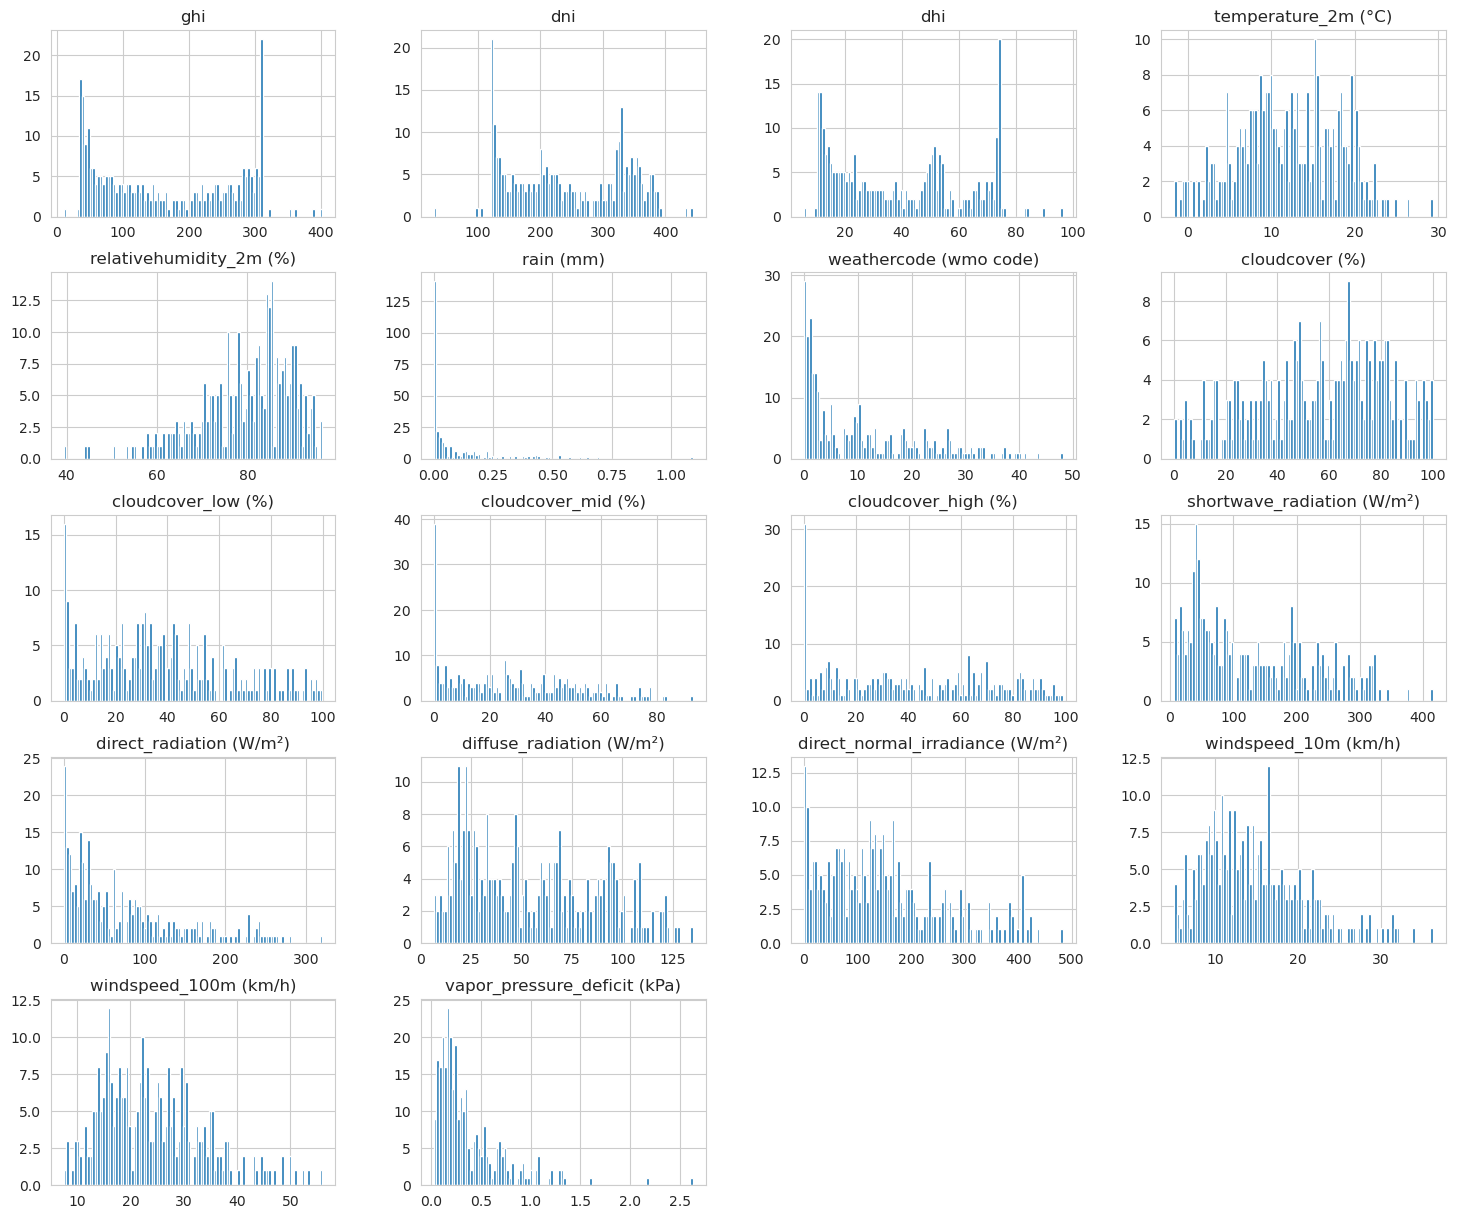

In [66]:
solar_power_x_train.hist(figsize=(18,15), bins=100);

#### Power transofrmation

In [67]:
# p_noise_x_trfmr = PowerTransformer().fit(noise_x_train)
# noise_x_train_p_trfrmd = pd.DataFrame(
#     data=p_noise_x_trfmr.transform(noise_x_train),
#     columns= noise_x_train.columns,
# )
# noise_x_test_p_trfrmd = pd.DataFrame(
#     data=p_noise_x_trfmr.transform(noise_x_test),
#     columns= noise_x_test.columns,
# )
# noise_x_train_p_trfrmd.hist(figsize=(12,6), bins=100);

#### Quantile transformation

In [68]:
# q_noise_x_trfmr = QuantileTransformer(output_distribution="normal").fit(noise_x_train)
# noise_x_train_q_trfrmd = pd.DataFrame(
#     data=q_noise_x_trfmr.transform(noise_x_train),
#     columns= noise_x_train.columns,
# )
# noise_x_test_q_trfrmd = pd.DataFrame(
#     data=q_noise_x_trfmr.transform(noise_x_test),
#     columns= noise_x_test.columns,
# )
# noise_x_train_q_trfrmd.hist(figsize=(15,10), bins=100);

### Targets

#### Source

In [69]:
solar_power_y_train.describe()

count    298.000000
mean      19.722301
std       17.331687
min        0.017250
25%        6.838365
50%       14.390583
75%       27.003177
max       84.405438
Name: solar_irrad, dtype: float64

<Axes: >

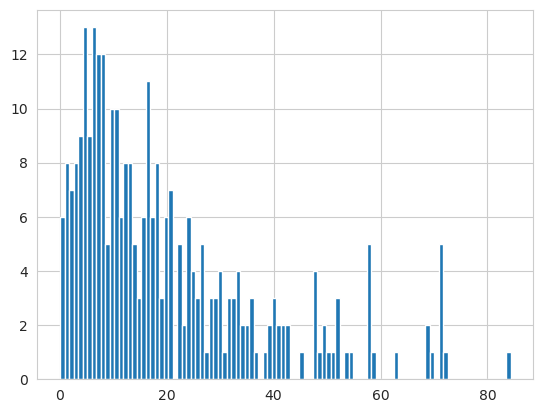

In [70]:
solar_power_y_train.hist(bins=100)

#### Power transformation

In [71]:
# p_noise_y_trfmr = PowerTransformer().fit(noise_y_train)
# noise_y_train_p_trfrmd = pd.DataFrame(
#     data=p_noise_y_trfmr.transform(noise_y_train),
#     columns= noise_y_train.columns,
# )
# display(noise_y_train_p_trfrmd.hist(figsize=(12,6), bins=100))
# noise_y_train_p_trfrmd.hist(figsize=(12,6), bins=100, log=True);

# Fit

## Without preprocessing

In [72]:
solar_power_model = LGBMRegressor()
solar_power_model.fit(solar_power_x_train, solar_power_y_train);

# Score

## Without preprocessing

In [73]:
solar_power_prediction = solar_power_model.predict(solar_power_x_test)
solar_power_mse = mean_squared_error(solar_power_y_test, solar_power_prediction)
solar_power_r2 = r2_score(solar_power_y_test, solar_power_prediction)
RMSE = solar_power_mse ** 0.5
MAE = np.mean(np.abs(solar_power_y_test.values - solar_power_prediction))
print(f"{solar_power_mse=} | {solar_power_r2=} | {RMSE=} | {MAE=}")

solar_power_mse=93.60740238223615 | solar_power_r2=0.7543580903846033 | RMSE=9.675091853943101 | MAE=6.128312076458718


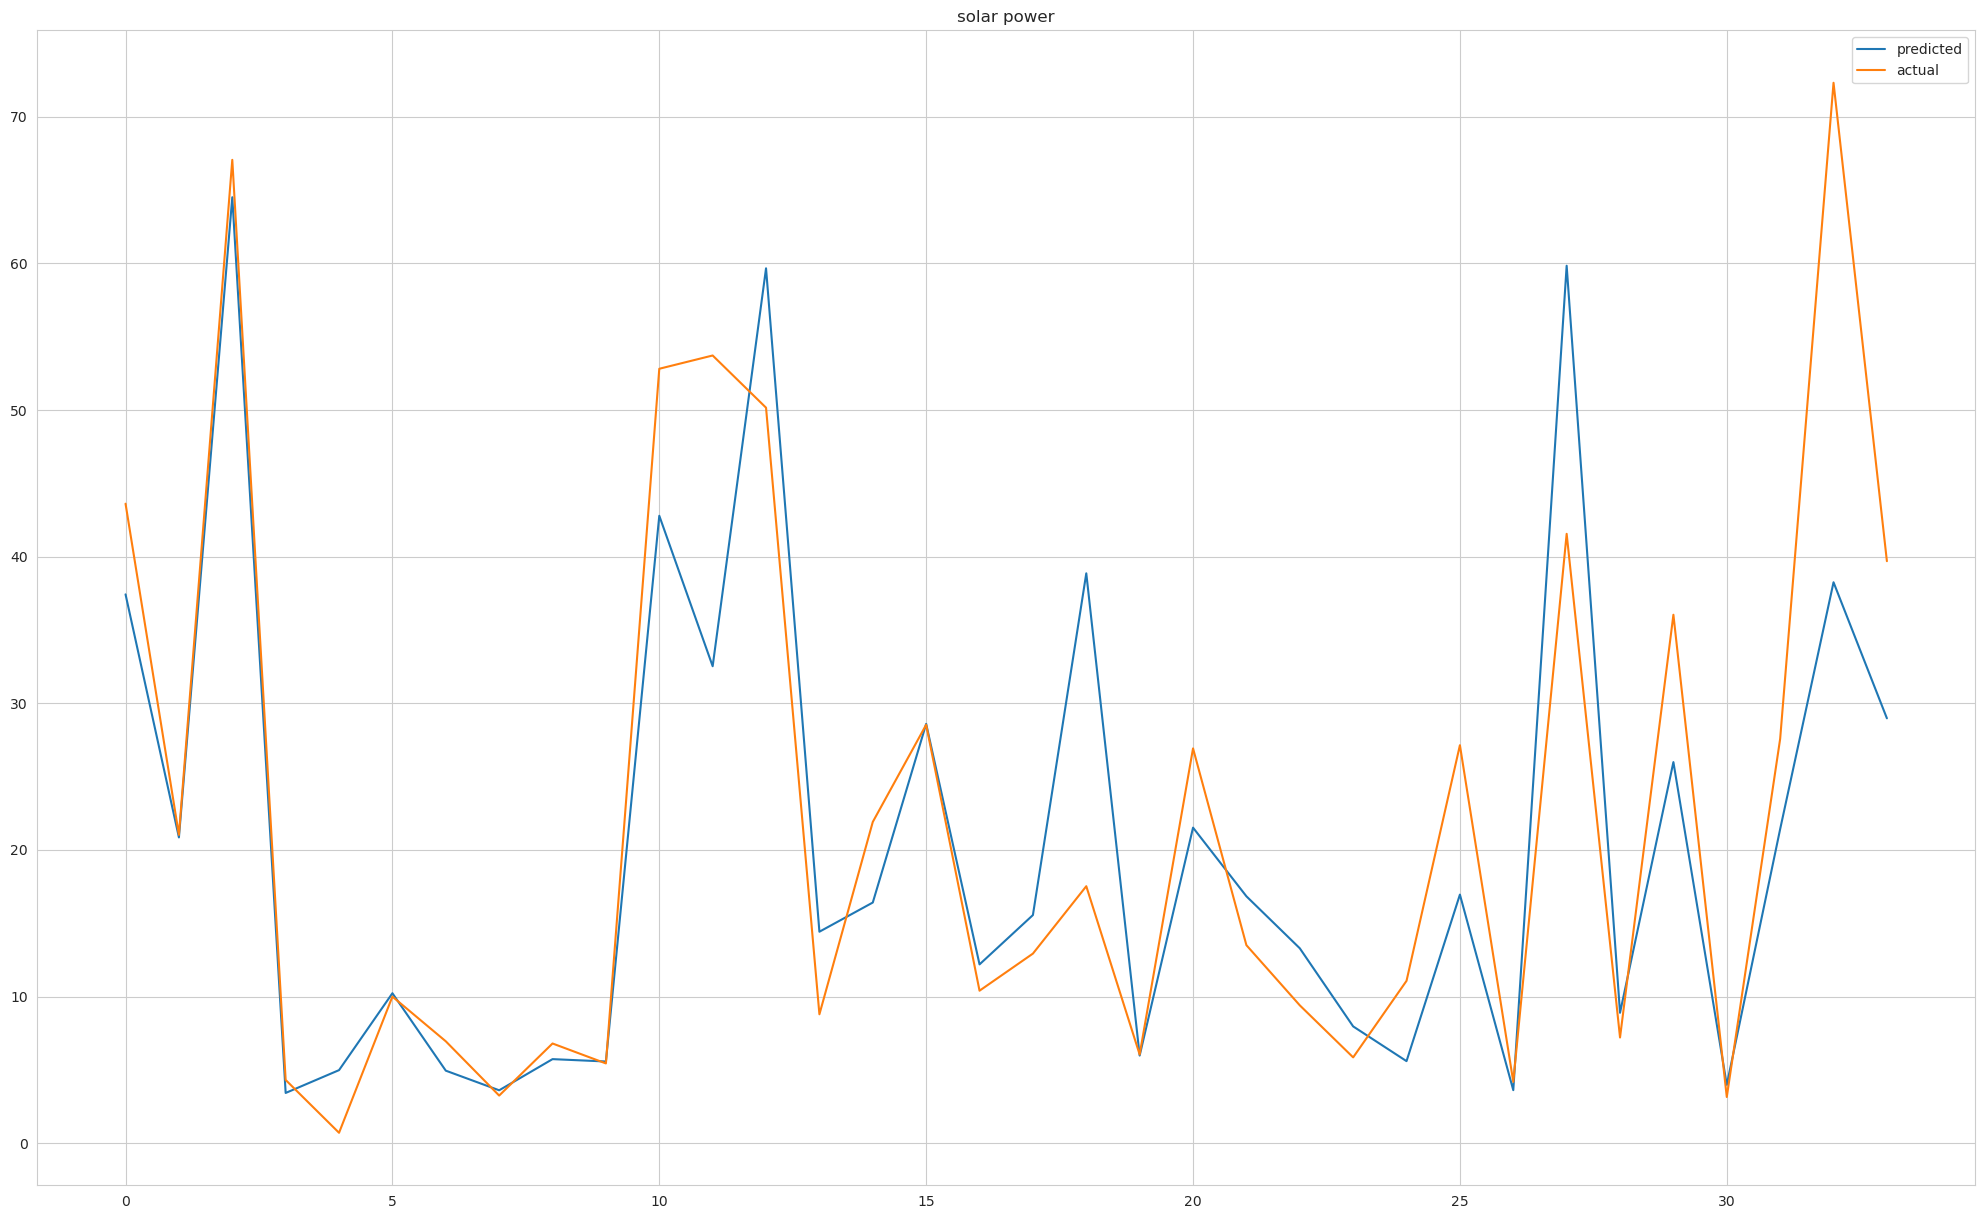

In [74]:
plt.figure(figsize=(25, 15))
plt.plot(solar_power_prediction, label='predicted')
plt.plot(solar_power_y_test.values, label='actual')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)

In [75]:
test_sample_x = test_sample[FEATURES_COLUMNS]
test_sample_y = test_sample[TARGET_COLUMN]

In [76]:
test_sample_y_prediction = solar_power_model.predict(test_sample_x)
test_sample_mse = mean_squared_error(test_sample_y, test_sample_y_prediction)
test_sample_r2 = r2_score(test_sample_y, test_sample_y_prediction)
RMSE = test_sample_mse ** 0.5
MAE = np.mean(np.abs(test_sample_y.values - test_sample_y_prediction))
print(f"{solar_power_mse=} | {solar_power_r2=} | {RMSE=} | {MAE=}")

solar_power_mse=93.60740238223615 | solar_power_r2=0.7543580903846033 | RMSE=9.706031311969218 | MAE=7.268345112947032


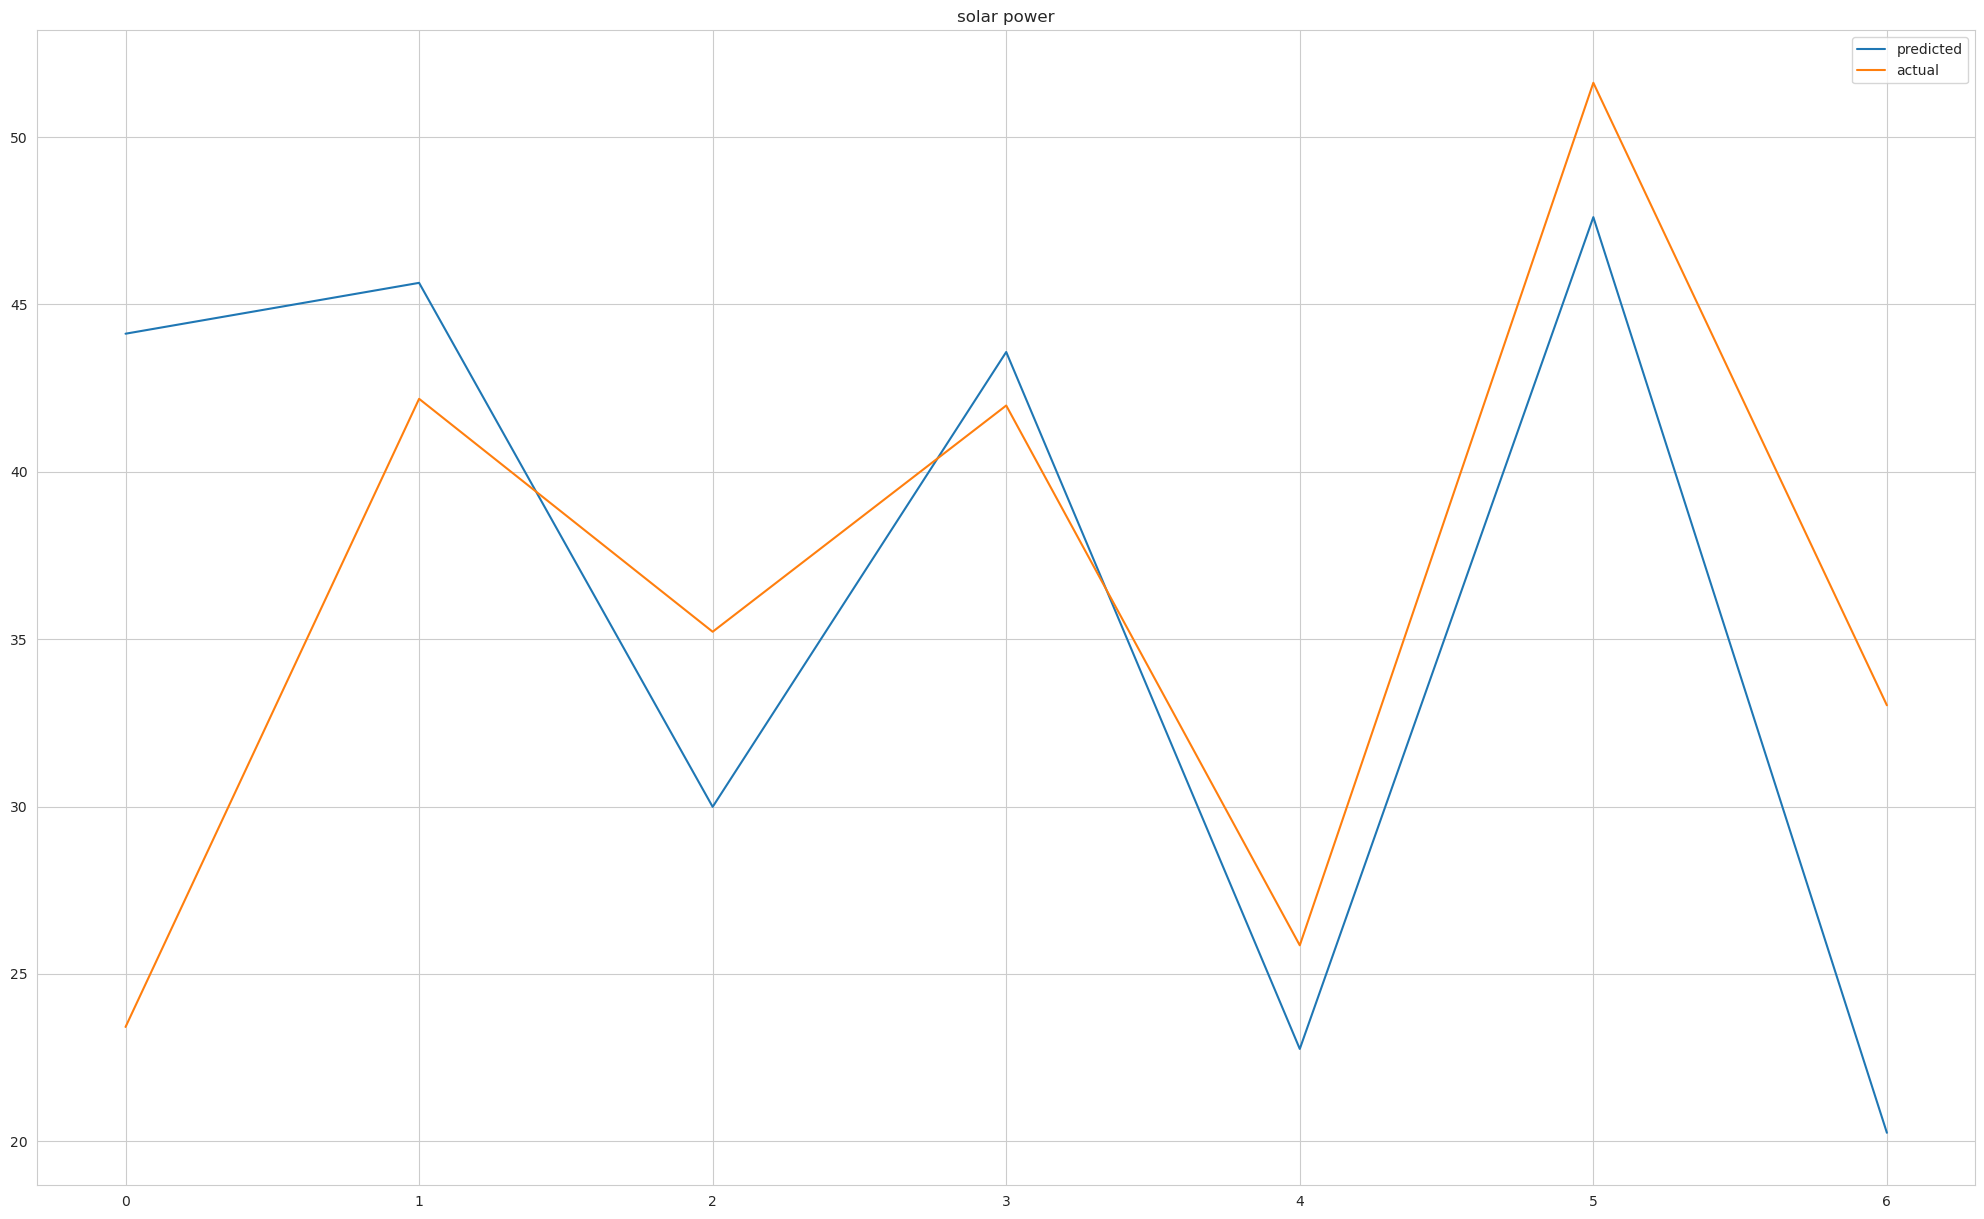

In [77]:
plt.figure(figsize=(25, 15))
plt.plot(test_sample_y_prediction, label='predicted')
plt.plot(test_sample_y.values, label='actual')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)

In [ ]:
# на час на день проверить качество нагрузка электролизёры сторонние апи

In [41]:

# использовать авторегресию и зависимость от первой разности
# уточнить зависимость между иррадиацией и мощностью панелей
# добавить теоретические иррадиации
    # Direct Normal Irradiation
    # Global Horizontal Irradiance
    # Diffuse Horizontal Irradiance
# попробовать бОльшее разрешение данных
# обучить на бОльшей выборке
# изменить модель
# убрать ночи ??

# ===========================
# самая лучшая модель когда используется предыдущее значение
# solar_power_mse=479212.60269496107 | solar_power_r2=0.8953146699127409 | RMSE=692.2518347357131
# solar_power_mse=407914.26451068616 | solar_power_r2=0.9105496521789492 | RMSE=802.5961809061683 | MAE=412.967252746227


In [42]:
from NN_model import Model

In [43]:
nn_model = Model()

In [44]:
len(solar_power_x_train) // 16

456

In [45]:
def train_model(model, epochs_number, x_train, y_train):
    batch_size = 16
    batches_number = len(x_train) // batch_size
    loss_on_epoch_list = []
    loss_by_epoch = []
    for epoch in range(epochs_number):
        loss_on_epoch = []
        for b in range(batches_number):
            inputs = x_train[b*batch_size : (b+1)*batch_size]
            labels = y_train[b*batch_size : (b+1)*batch_size]
            loss_item = model.fit(inputs, labels)
            loss_on_epoch.append(loss_item)
            print(f"{epoch} => {b} => {loss_item}")
        loss_on_epoch_list.append(loss_on_epoch)
        loss_by_epoch.append(loss_item)
    return loss_on_epoch_list, loss_by_epoch

In [46]:
loss_on_epoch_list, loss_by_epoch = train_model(nn_model, 500, solar_power_x_train.values, solar_power_y_train.values)

/home/eduard/miniconda3/envs/modeling_control/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 => 0 => 9469612.0
0 => 1 => 5824835.5
0 => 2 => 8057950.5
0 => 3 => nan
0 => 4 => nan
0 => 5 => nan
0 => 6 => nan
0 => 7 => nan
0 => 8 => nan
0 => 9 => nan
0 => 10 => nan
0 => 11 => nan
0 => 12 => nan
0 => 13 => nan
0 => 14 => nan
0 => 15 => nan
0 => 16 => nan
0 => 17 => nan
0 => 18 => nan
0 => 19 => nan
0 => 20 => nan
0 => 21 => nan
0 => 22 => nan
0 => 23 => nan
0 => 24 => nan
0 => 25 => nan
0 => 26 => nan
0 => 27 => nan
0 => 28 => nan
0 => 29 => nan
0 => 30 => nan
0 => 31 => nan
0 => 32 => nan
0 => 33 => nan
0 => 34 => nan
0 => 35 => nan
0 => 36 => nan
0 => 37 => nan
0 => 38 => nan
0 => 39 => nan
0 => 40 => nan
0 => 41 => nan
0 => 42 => nan
0 => 43 => nan
0 => 44 => nan
0 => 45 => nan
0 => 46 => nan
0 => 47 => nan
0 => 48 => nan
0 => 49 => nan
0 => 50 => nan
0 => 51 => nan
0 => 52 => nan
0 => 53 => nan
0 => 54 => nan
0 => 55 => nan
0 => 56 => nan
0 => 57 => nan
0 => 58 => nan
0 => 59 => nan
0 => 60 => nan
0 => 61 => nan
0 => 62 => nan
0 => 63 => nan
0 => 64 => nan
0 => 65 => nan
0 

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(25, 15))
plt.plot(loss_by_epoch, label='loss_by_epoch')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)

In [ ]:
plt.figure(figsize=(25, 15))
plt.plot(loss_on_epoch_list[0], label='loss_on_epoch_list_0')
plt.plot(loss_on_epoch_list[3], label='loss_on_epoch_list_3')
plt.plot(loss_on_epoch_list[7], label='loss_on_epoch_list_7')
plt.plot(loss_on_epoch_list[400], label='loss_on_epoch_list_400')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)

In [ ]:
solar_power_prediction = nn_model.predict(solar_power_x_test.values)
solar_power_mse = mean_squared_error(solar_power_y_test, solar_power_prediction)
solar_power_r2 = r2_score(solar_power_y_test, solar_power_prediction)
RMSE = solar_power_mse ** 0.5
print(f"{solar_power_mse=} | {solar_power_r2=} | {RMSE=}")

In [ ]:
plt.figure(figsize=(25, 15))
plt.plot(solar_power_prediction[-100:], label='predicted')
plt.plot(solar_power_y_test.values[-100:], label='actual')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)